<a href="https://colab.research.google.com/github/aurimas13/Revenue-Forecast/blob/main/Daily_Revenue_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Overview** </b>

Then Revenue Forecast project found at this [GitHub repo](https://github.com/aurimas13/Revenue-Forecast) aimed to predict daily and monthly revenue using time series data and weather features by comparing the performance of three different models: Long Short-Term Memory (LSTM), Prophet, and Autoregressive Integrated Moving Average (ARIMA). Further overview at the repository.

# <b> Installations </b>

Using the `Prophet` and `pmdarima` packages for time series forecasting. To install these packages, run the following commands:


In [ ]:
!python -m pip install prophet
!pip install pmdarima

# <b> Imports </b>

Importing several libraries and packages to perform time series forecasting and data analysis. 

In [100]:
import warnings
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from pmdarima import auto_arima

# Disable warnings and set logger level
warnings.filterwarnings("ignore")
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

# Set the default figure size
plt.rcParams['figure.figsize'] = (20, 12)

# <b> Loading data </b>

Loading two separate datasets of Revenue and Weather from an Excel file hosted on GitHub.

In [101]:
url = "https://github.com/aurimas13/Revenue-Forecast/blob/main/Dataset/Barbora%20Homework.xlsx?raw=true"
revenue_data = pd.read_excel(url, sheet_name='Revenue', parse_dates=['Date'], engine='openpyxl')
weather_data = pd.read_excel(url, sheet_name='Weather', parse_dates=['dt'], engine='openpyxl')

# <b> Exploratory Data Analysis

In this Exploratory Data Analysis (EDA) section, we performed several steps to better understand the structure and characteristics of the revenue and weather datasets. The analysis includes:

1. **Inspecting the datasets**: We displayed the first few rows of both the revenue and weather data to get a general idea of their structure and columns.

2. **Analyzing revenue data**: We identified the top 5 highest revenue values and the most common revenue values to gain insights into the revenue distribution.

3. **Data types examination**: We printed the data types of the revenue and weather data columns to ensure they are in the appropriate format for further analysis.

4. **Converting categorical data to numerical data**: We converted the categorical features in the weather data ('wind', 'condition', 'time') to numerical data using their category codes. This step is necessary for creating a heatmap of correlations later in the analysis.

5. **Visualizing revenue data**: We created a scatter plot of revenue data against time to identify any trends, patterns, or outliers in the revenue.

6. **Correlation heatmap**: We generated a correlation heatmap for the weather data's features to assess any strong relationships between the numeric features.

7. **Box plots for numeric features**: We created box plots for each numeric feature in the weather data to visualize their distributions and identify any potential outliers or extreme values.

8. **Missing values examination**: We checked for missing values in both the revenue and weather data to determine if any data cleaning or imputation is required.

9. **Duplicate rows check**: We examined the datasets for any duplicate rows, which may need to be removed before further analysis.

By performing these steps, we gained a better understanding of the datasets and can identify any necessary preprocessing steps before moving on to the modeling phase.

In [102]:
# Inspecting revenue_data and weather_data
print(revenue_data.head())
print(weather_data.head())

        Date     Revenue
0 2018-01-01        0.00
1 2018-01-02        0.00
2 2018-01-03  3087464.68
3 2018-01-04  2770763.36
4 2018-01-05        0.00
       time  temperature  dew_point  humidity wind  wind_speed  pressure  \
0  00:20:00            0          0       1.0    S          11       982   
1  00:50:00            0          0       1.0    S          14       983   
2  01:20:00            0          0       1.0    S          11       982   
3  01:50:00            0          0       1.0    S          14       982   
4  02:20:00            0          0       1.0    S          14       981   

   precipitation      condition         dt  
0              0           Mist 2018-01-01  
1              0           Mist 2018-01-01  
2              0           Mist 2018-01-01  
3              0  Mostly Cloudy 2018-01-01  
4              0     Light Rain 2018-01-01  


In [103]:
# Get the top 5 maximum Revenue values
top_5_revenue_values = revenue_data['Revenue'].nlargest(5)

# Print the top 5 maximum Revenue values
print(top_5_revenue_values)

1136    1.105855e+12
1178    1.257807e+07
824     1.197323e+07
1129    1.177268e+07
1115    1.163311e+07
Name: Revenue, dtype: float64


In [104]:
# Get the most common values in the 'Revenue' column
most_common_values = revenue_data['Revenue'].value_counts()

# Print the most common values
print(most_common_values)


0.00           5
8796735.00     1
9401918.80     1
10733644.52    1
10839401.60    1
              ..
2962163.40     1
2644403.36     1
2585825.36     1
3317606.80     1
6373218.32     1
Name: Revenue, Length: 1745, dtype: int64


In [105]:
# Looking at data types of revenue and weather data
print(revenue_data.info())
print(weather_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1749 non-null   datetime64[ns]
 1   Revenue  1749 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86990 entries, 0 to 86989
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   time           86990 non-null  object        
 1   temperature    86990 non-null  int64         
 2   dew_point      86990 non-null  int64         
 3   humidity       86990 non-null  float64       
 4   wind           86990 non-null  object        
 5   wind_speed     86990 non-null  int64         
 6   pressure       86990 non-null  int64         
 7   precipitation  86990 non-null  int64         
 8   condition      86990 non-

In [106]:
# Converting categorical data to numerical data in weather_data for heatmap
weather_data['wind'] = weather_data['wind'].astype('category').cat.codes
weather_data['condition'] = weather_data['condition'].astype('category').cat.codes
weather_data['time'] = weather_data['condition'].astype('category').cat.codes

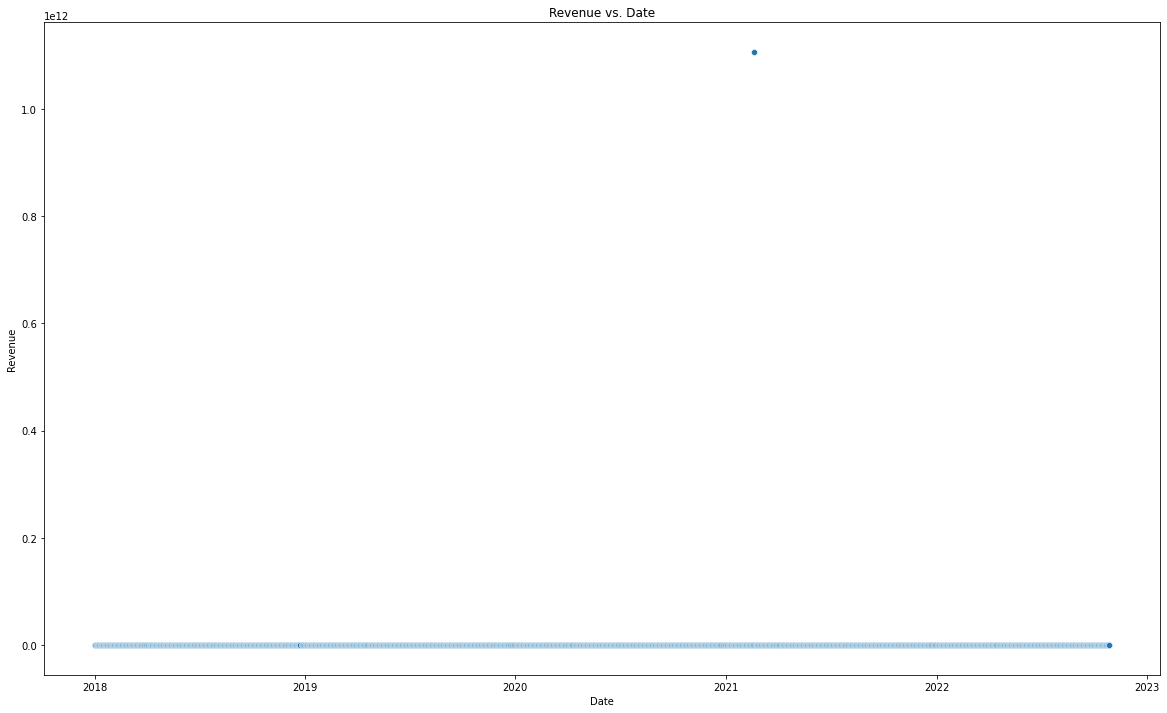

In [107]:
# Identifying if there are any outliers for revenue_data
sns.scatterplot(data=revenue_data, x='Date', y='Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue vs. Date')
plt.show()

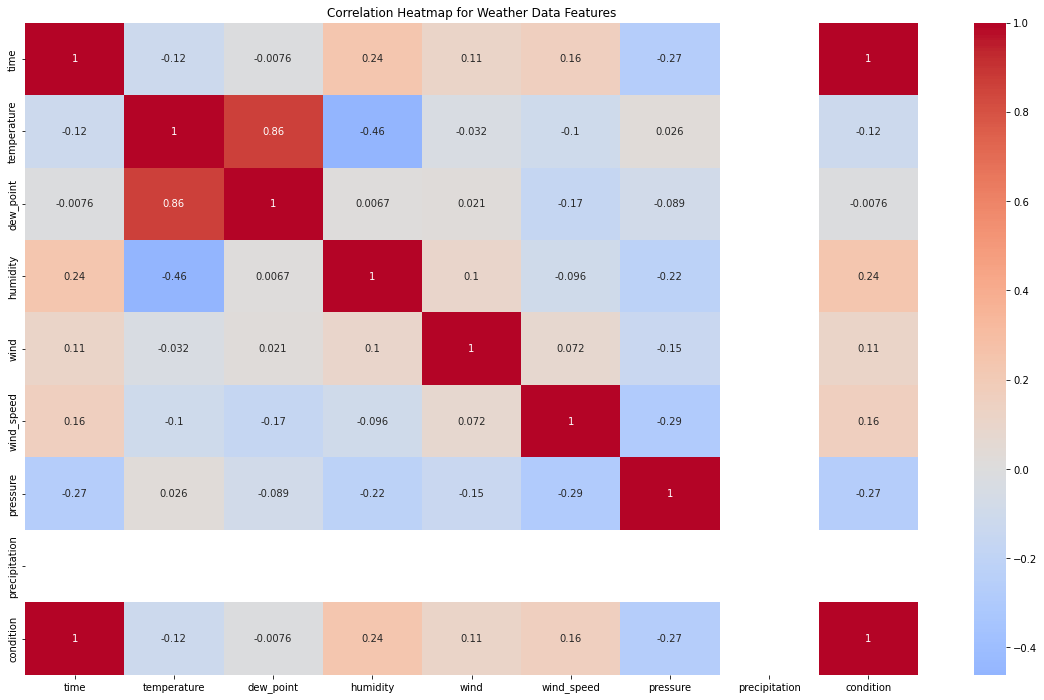

In [108]:
# Visualising heatmap for weather_data
sns.heatmap(weather_data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap for Weather Data Features')
plt.show()

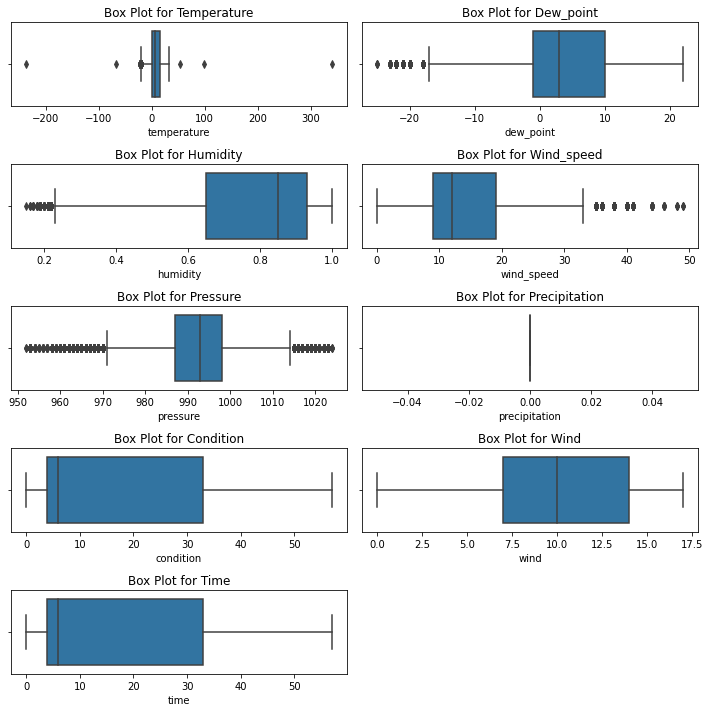

In [109]:
# Box plots for numeric features in weather_data
numeric_features = ['temperature', 'dew_point', 'humidity', 'wind_speed', 'pressure', 'precipitation', 'condition', 'wind', 'time']

n_features = len(numeric_features)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

# Create a single figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 2))
axes = axes.flatten()

# Create box plots for each numeric feature as subplots
for i, feature in enumerate(numeric_features):
    sns.boxplot(data=weather_data, x=feature, ax=axes[i])
    axes[i].set_title(f'Box Plot for {feature.capitalize()}')

# Remove any extra subplot (if any)
for i in range(n_features, n_rows * n_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [110]:
# Missing values
print(revenue_data.isnull().sum())
print(weather_data.isnull().sum())

Date       0
Revenue    0
dtype: int64
time             0
temperature      0
dew_point        0
humidity         0
wind             0
wind_speed       0
pressure         0
precipitation    0
condition        0
dt               0
dtype: int64


In [111]:
# Checking duplicate rows in the datasets
print(revenue_data.duplicated().sum())
print(weather_data.duplicated().sum())

0
10346


# <b> Data Preprocessing </b>

In the Data Preprocessing stage, several steps were performed to prepare the data for modeling. These steps included:

1. **Cleaning Data**:

- Outliers were detected and removed for each numeric feature in the weather data using the interquartile range (IQR) method.
- Scatter plots were created for each numeric feature to visualize the cleaned data.
- Duplicate rows were removed from the weather data.
- Unnecessary columns (precipitation, wind, time, and condition) were dropped from the weather data.
- Box plots were created for the remaining numeric features in the weather data.
- Outliers in the revenue data were removed by filtering out rows with revenue values greater than 10^7 based on the exploratory data analysis.

2. **Feature Engineering**:

- The weather data was aggregated on a daily basis using mean and median functions.
- Missing values were filled using linear interpolation.
- Rolling window features were created for a window size of 7 days, including - - 7-day averages for temperature, dew_point, humidity, and pressure, and a 7-day median for wind_speed.
- The original columns for temperature, dew_point, humidity, wind_speed, and pressure were dropped, as the newly created rolling window features replaced them. 

3. **Merging Data**:

- The cleaned revenue data and daily weather data were merged on the 'Date' and 'dt' columns.
- The duplicate 'dt' column was dropped.
- A lagged revenue column was added to the merged data, and any missing values were filled with zeros.
- Rows containing NaN values were dropped, and the final cleaned and merged dataset was obtained.

These steps resulted in a well-structured and cleaned dataset, which can now be used for modeling and analysis.

## <b> 1. Cleaning data </b>

The following steps were taken to clean both weather and revenue data:

1. **Outlier Removal**:

- A function is_outlier_iqr() was defined to identify outliers using the interquartile range (IQR) method with a specified multiplier (default is 1.5).
- A copy of the weather data was created, and the function was applied to each numeric feature. Outliers were removed based on the generated mask.
- Scatter plots were created for each numeric feature to visualize the cleaned data. These plots helped in assessing the impact of outlier removal on the data distribution.

2. **Duplicate Removal**:

- Duplicate rows were removed from the cleaned weather data, ensuring that only unique records were retained.

3. **Dropping Unnecessary Columns**:

- Columns with less relevance or redundant information, such as precipitation, wind, time, and condition, were dropped from the weather data.

4. **Box Plots**:

- Box plots were created for each remaining numeric feature in the weather data to visualize their distribution and confirm the absence of outliers.

5. **Revenue Data Outlier Removal**:

- Based on exploratory data analysis, a threshold value of 10^7 was set for revenue data. Rows with revenue values greater than this threshold were considered outliers and were removed from the dataset.

These cleaning steps resulted in a refined dataset without outliers, duplicates, and unnecessary columns, which is better suited for further processing and analysis.

In [112]:
# Removing outliers by defining a function
def is_outlier_iqr(data, column, multiplier=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return (data[column] < lower_bound) | (data[column] > upper_bound)

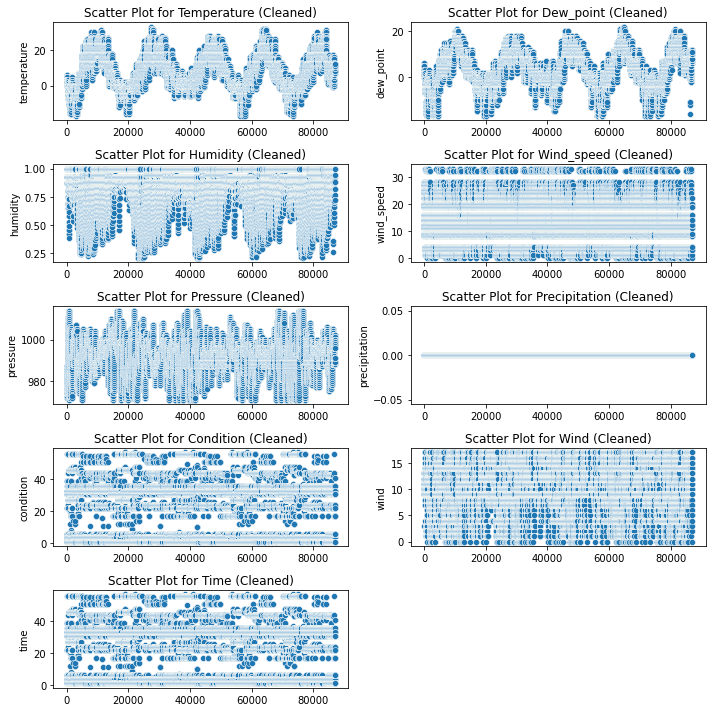

In [113]:
# Create a copy of the DataFrame to store the weather cleaned data
weather_data_cleaned = weather_data.copy()

# Remove outliers for each numeric feature
for feature in numeric_features:
    outlier_mask = is_outlier_iqr(weather_data_cleaned, feature)
    weather_data_cleaned = weather_data_cleaned[~outlier_mask]

# Calculate the number of rows and columns for the subplots
n_features = len(numeric_features)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

# Create a single figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 2))
axes = axes.flatten()

# Create scatter plots for each numeric feature as subplots
for i, feature in enumerate(numeric_features):
    sns.scatterplot(data=weather_data_cleaned, x=weather_data_cleaned.index, y=feature, ax=axes[i])
    axes[i].set_title(f'Scatter Plot for {feature.capitalize()} (Cleaned)')

# Remove any extra subplot (if any)
for i in range(n_features, n_rows * n_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [114]:
# Removing duplicates
weather_data = weather_data_cleaned.drop_duplicates()
print(weather_data.duplicated().sum())

0


In [115]:
# Remove values of wind, time, condition and precipitation
weather_data.drop(['wind','time','condition','precipitation'], axis=1, inplace=True)

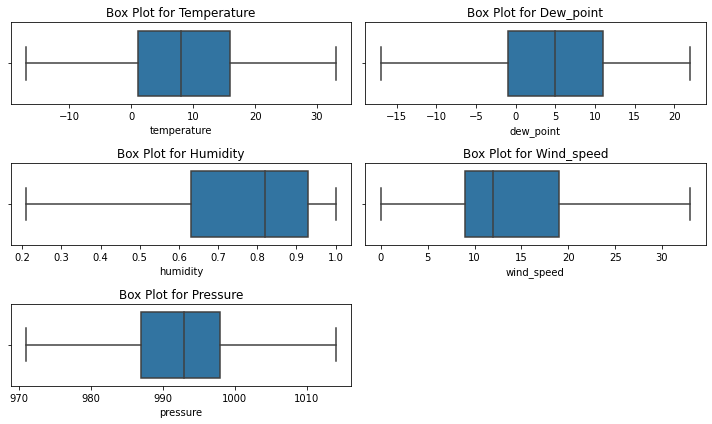

In [116]:
# Box plots for numeric features in weather_data
numeric_features = ['temperature', 'dew_point', 'humidity', 'wind_speed', 'pressure']

# Calculate the number of rows and columns for the subplots
n_features = len(numeric_features)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

# Create a single figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 2))
axes = axes.flatten()

# Create box plots for each numeric feature as subplots
for i, feature in enumerate(numeric_features):
    sns.boxplot(data=weather_data, x=feature, ax=axes[i])
    axes[i].set_title(f'Box Plot for {feature.capitalize()}')

# Remove any extra subplot (if any)
for i in range(n_features, n_rows * n_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [117]:
# Filter rows that have Revenue less than or equal to 10^7 after inspecting and doing EDA. Simply removing outliers
revenue_data_cleaned = revenue_data[revenue_data['Revenue'] <= 10**7]
print(revenue_data_cleaned.isna().sum().sum())

0


# <b> 2. Feature Engineering </b>

The following steps were taken to create new features and transform existing features in the weather data:

1. **Aggregation**:

- The weather data was resampled to daily level using the 'dt' column (date-time column) as the index.
- The mean values of temperature, dew_point, humidity, and pressure were calculated, while the median value was computed for wind_speed.

2. **Handling Missing Values**:

- The 'dt' column was temporarily converted to an integer format (seconds since 1970-01-01) to apply linear interpolation for filling missing values in the data.
- After filling the missing values, the 'dt' column was converted back to the datetime format.
3. **Rolling Window Features**:

- A window size of 7 days was set, and rolling window features were created for each of the aggregated features (temperature, dew_point, humidity, wind_speed, and pressure).
- The mean values for temperature, dew_point, humidity, and pressure were computed over a 7-day window, while the median value was calculated for wind_speed over the same period.

4. **Filling NaNs in Rolling Window Features**:
- The first 6 days of the rolling window features contained NaN values due to the window size. These NaNs were filled with specified values to ensure that the dataset remains consistent.

5. **Dropping Original Columns**:

- The original columns (temperature, dew_point, humidity, wind_speed, and pressure) were dropped from the dataset, as the newly created rolling window features effectively captured the necessary information.


These feature engineering steps transformed the weather data into a more meaningful format for further analysis, creating aggregated and rolling window features that better capture the trends and patterns in the data.

In [118]:
# Aggregate weather_data on 'dt' to daily level
daily_weather_data = weather_data.resample('D', on='dt').agg({
    'temperature': 'mean',
    'dew_point': 'mean',
    'humidity': 'mean',
    'wind_speed': 'median',
    'pressure': 'mean',
}).reset_index()

# Convert 'dt' column to integer
daily_weather_data['dt'] = daily_weather_data['dt'].astype(int) // 10**9

# Fill missing values with linear interpolation
daily_weather_data.interpolate(method='linear', inplace=True)

# Convert 'dt' column back to datetime format
daily_weather_data['dt'] = pd.to_datetime(daily_weather_data['dt'], unit='s')

window_size = 7

# Create rolling window features
daily_weather_data['temperature_7d_avg'] = daily_weather_data['temperature'].rolling(window=window_size).mean()
daily_weather_data['dew_point_7d_avg'] = daily_weather_data['dew_point'].rolling(window=window_size).mean()
daily_weather_data['humidity_7d_avg'] = daily_weather_data['humidity'].rolling(window=window_size).mean()
daily_weather_data['wind_speed_7d_median'] = daily_weather_data['wind_speed'].rolling(window=window_size).median()
daily_weather_data['pressure_7d_avg'] = daily_weather_data['pressure'].rolling(window=window_size).mean()

# Fill the NaNs in the first 6 days with the specified values
daily_weather_data['temperature_7d_avg'].fillna(0, inplace=True, limit=6)
daily_weather_data['dew_point_7d_avg'].fillna(0, inplace=True, limit=6)
daily_weather_data['humidity_7d_avg'].fillna(1, inplace=True, limit=6)
daily_weather_data['pressure_7d_avg'].fillna(981, inplace=True, limit=6)
daily_weather_data['wind_speed_7d_median'].fillna(14, inplace=True, limit=6)

# Drop the original columns
daily_weather_data.drop(columns=['temperature', 'dew_point', 'humidity', 'wind_speed', 'pressure'], inplace=True)

# <b> 3. Merging Data </b>

Here's an expanded explanation for the Merging Data subparagraph based on the provided code cells:

1. **Merge revenue_data and daily_weather_data**:

- The cleaned revenue_data and the engineered daily_weather_data were merged on their respective date columns ('Date' and 'dt').
- An 'inner' merge was performed, which means that only the rows with matching dates in both DataFrames were included in the merged_data DataFrame.
2. **Drop duplicate date column**:

- After merging the DataFrames, the 'dt' column from daily_weather_data was a duplicate of the 'Date' column from revenue_data, so the 'dt' column was dropped to avoid redundancy.
3. **Lagged Revenue Feature**:

- A new feature called 'lagged_revenue' was created by shifting the 'Revenue' column by one row, effectively providing the revenue of the previous day.
- Any NaN value resulting from this operation was filled with 0.

4. **Replace Zeros with NaNs**:

- In order to properly handle missing data, all zeros in the merged_data DataFrame were replaced with NaN values.
5. **Drop Rows with NaN Values**:

- Any row containing NaN values was dropped from the merged_data DataFrame, ensuring that only complete data entries were retained for further analysis.

By merging the revenue_data and daily_weather_data, you have created a comprehensive dataset that combines both weather and revenue information. This dataset will be useful for further analysis, such as building predictive models or exploring correlations between weather and revenue.

In [119]:
# Merge revenue_data and daily_weather_data on the Date and dt columns
merged_data = pd.merge(revenue_data_cleaned, daily_weather_data, left_on='Date', right_on='dt', how='inner')

In [120]:
# Looking at NaNs
print(merged_data.isna().sum().sum())

0


In [121]:
# Drop the 'dt' column since it's a duplicate of 'Date'
merged_data.drop(columns=['dt'], inplace=True)

In [122]:
# Add the lagged revenue column to the merged_data
merged_data['lagged_revenue'] = merged_data['Revenue'].shift(1).fillna(0)

In [123]:
# Replace zeros with NaNs
merged_data = merged_data.replace(0, np.nan)

In [124]:
# Drop rows with NaN values
merged_data = merged_data.dropna()
print(merged_data.isna().sum().sum())

0


# <b> Splitting Data </b>

In this section, the merged dataset was split into training and test sets based on a specific date. The cutoff date chosen was January 1, 2022, which separates the data into two distinct periods. All data before this date was assigned to the training set, while data on or after this date was assigned to the test set. This temporal split ensures that the model learns from historical data and is then evaluated on more recent, unseen data.

Next, the features (X) and target variable (y) were separated for both the training and test sets. The 'Date' and 'Revenue' columns were removed from the feature sets (X_train and X_test) since 'Date' is not directly relevant to the model's predictions, and 'Revenue' is the target variable to be predicted. The 'Revenue' column was used as the target variable for both the training and test sets (y_train and y_test).

In [125]:
# Split the data into train and test sets
train_data = merged_data[merged_data['Date'] < '2022-01-01']
test_data = merged_data[merged_data['Date'] >= '2022-01-01']

# Separate the features (X) and the target (y)
X_train = train_data.drop(columns=['Date', 'Revenue'])
y_train = train_data['Revenue']
X_test = test_data.drop(columns=['Date', 'Revenue'])
y_test = test_data['Revenue']

# <b> Scaling Data </b>

In this section, the feature data was standardized using the StandardScaler from scikit-learn. Standardization scales the features by transforming them to have zero mean and unit variance. This process helps to ensure that all features have equal weight in the model and can improve model performance, particularly for algorithms that are sensitive to the scale of input features.

The StandardScaler was fit on the training set (X_train) and then used to transform both the training and test sets (X_train_scaled and X_test_scaled). It is important to fit the scaler only on the training data to prevent information leakage from the test set. After scaling, the transformed features were converted back to DataFrames with the same column names as the original data.

Additionally, the target variable 'Revenue' (y_train) was also scaled using a separate StandardScaler instance (y_scaler). This is sometimes done to ensure that the target variable is also on a similar scale as the input features, which can be beneficial for certain machine learning algorithms.

In [126]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled features back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Initialize a StandardScaler instance for the target variable y
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.to_numpy(dtype='float32').reshape(-1, 1))

# <b> Device Check </b>

Check if GPU is available and set the device accordingly.

In [127]:
# Checking device to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# <b> Defining MAPE & RMSE Metrics </b>

Maunually defining MAPE & RMSE Metrics for a better accuracy response on them.

In [128]:
# Definining the MAPE metric as a MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define RMSE metric as RMSE function
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# <b> 1<sup>st</sup> model - LSTM </b>

LSTM (Long Short-Term Memory) model was implemented to predict the revenue based on the preprocessed and scaled data. LSTM is a type of Recurrent Neural Network (RNN) that can capture long-range dependencies in sequence data, making it a suitable choice for time series forecasting.

## **Neural Net Architecture**

The LSTM model class is defined with input_size, hidden_size, num_layers, output_size, and dropout_rate as its parameters. The architecture consists of an LSTM layer, followed by a dropout layer to prevent overfitting, and a fully connected linear layer to produce the final output.

In [129]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Adding sequence_length dimension
        x = x.unsqueeze(1)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Apply dropout
        out = self.dropout(out)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


## **Hyperparameters and Conversion**:

Various hyperparameters are set for the model, such as input_size, hidden_size, num_layers, output_size, learning_rate, batch_size, and dropout_rate. The input data is then converted from DataFrames to NumPy arrays and then to PyTorch tensors.



In [130]:
# Define Hyperparameters
input_size = X_train_scaled.shape[1]
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001
batch_size = 32
dropout_rate = 0.2

# Convert DataFrames to NumPy arrays and then to PyTorch tensors
X_train_numpy = X_train_scaled.to_numpy(dtype='float32')
y_train_numpy = y_train.to_numpy(dtype='float32').reshape(-1, 1)
X_train_tensor = torch.tensor(X_train_numpy)
y_train_tensor = torch.tensor(y_train_scaled)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## **Initialize Net & Define Loss with Optimizer**

The model is instantiated and transferred to the appropriate device (GPU/CPU). The Mean Squared Error (MSELoss) is used as the loss function, and the Adam optimizer is employed for weight updates during training.

In [131]:
# Initialize Net
model = LSTM(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)

# Define Loss with Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


## **Training and Testing**

The model is trained for a specified number of epochs. In each epoch, the training data is iterated using a DataLoader with a specified batch_size, and the model weights are updated by backpropagation. After every 10 epochs, the training loss is printed.

In [132]:
# Train and Test
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(-1, 1)  # Reshape the output tensor
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0992
Epoch [20/100], Loss: 0.0528
Epoch [30/100], Loss: 0.1447
Epoch [40/100], Loss: 0.1969
Epoch [50/100], Loss: 0.0638
Epoch [60/100], Loss: 0.1344
Epoch [70/100], Loss: 0.0894
Epoch [80/100], Loss: 0.0594
Epoch [90/100], Loss: 0.1489
Epoch [100/100], Loss: 0.1223


## **Evaluation**

The model is switched to evaluation mode, and predictions are made on the test set. The predicted values are inverse-transformed using the target scaler to obtain the original scale. Various performance metrics, such as Mean Squared Error (MSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE) are calculated to evaluate the model's performance on the test set.

In [133]:
# Model evaluation
model.eval()
X_test_np = X_test_scaled.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.float32)

X_test_tensor = torch.tensor(X_test_np).to(device)
y_test_tensor = torch.tensor(y_test_np).to(device)

with torch.no_grad():
    y_pred = model(X_test_tensor)

y_pred = y_pred.cpu().detach().numpy()
y_pred_unscaled = y_scaler.inverse_transform(y_pred)

mse = mean_squared_error(y_test, y_pred_unscaled)
mae = mean_absolute_error(y_test, y_pred_unscaled)
mape = mean_absolute_percentage_error(y_test, y_pred_unscaled)
rmse = calculate_rmse(y_test, y_pred_unscaled)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')

MSE: 906596667467.8273
MAE: 751881.5288698644
MAPE: 19.8297738625878
RMSE: 952153.6994980522


This LSTM model serves as the first approach for predicting revenue and provides a baseline for comparing other models and techniques.

# <b> 2<sup>nd</sup> model - Prophet </b>

The Prophet model, a popular forecasting tool developed by Facebook, was implemented for predicting revenue based on the historical data. The model was designed to handle time series data with multiple seasonalities and trends, making it suitable for daily revenue prediction.



## **Prepare Data**

The training data is prepared for the Prophet model by selecting the 'Date' and 'Revenue' columns and renaming them to 'ds' and 'y', respectively, as required by the Prophet library.

In [134]:
# Prepare the data for the Prophet model
prophet_train_data = train_data[['Date', 'Revenue']].rename(columns={'Date': 'ds', 'Revenue': 'y'})

## **Initialize the model**

The Prophet model is instantiated and fitted to the prepared training data.

In [135]:
# Create and fit the Prophet model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_train_data);

## **Prediction**

A future DataFrame is created for the same number of days as in the test set. The model makes predictions on this future DataFrame, generating a forecast for the test period.

In [136]:
# Create a future dataframe for the number of days in the test set
num_days = len(test_data)
future = prophet_model.make_future_dataframe(periods=num_days)
prophet_forecast = prophet_model.predict(future)

## **Evaluation**

The predictions are evaluated by comparing them with the true values from the original test_data. Mean Squared Error (MSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE) are calculated to assess the model's performance on the test set.

In [137]:
# Evaluate the model
test_forecast = prophet_forecast.tail(num_days)

# Get the true values from the original test_data
y_true = test_data['Revenue'].values

# Calculate the errors
y_pred = test_forecast['yhat'].values

# Calculate the errors
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = calculate_rmse(y_test, y_pred_unscaled)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')

MSE: 2118079304566.8706
MAE: 1243461.7013827802
MAPE: 17.520882523000132
RMSE: 952153.6994980522


This Prophet model provides an alternative approach to predicting revenue and is better than the LSTM model to determine the most suitable model for this problem.





# <b> 3<sup>rd</sup> model - ARIMA </b>

Lastly, the ARIMA (AutoRegressive Integrated Moving Average) model, a classical time series forecasting method, was implemented for predicting revenue based on the given and preprocessed data. ARIMA combines autoregression, differencing, and moving average components to capture various patterns in the time series data.

## **Prepare Data**

The training data is prepared for the ARIMA model by selecting the 'Date' and 'Revenue' columns and setting the 'Date' as the index, creating a time series data format suitable for the ARIMA model.

In [138]:
# Prepare the time series data for the ARIMA model
ts_data = train_data[['Date', 'Revenue']]
ts_data.set_index('Date', inplace=True)

## **Fit**

The ARIMA model is instantiated with the specified order (p, d, q), where 'p' represents the autoregressive order, 'd' denotes the differencing order, and 'q' signifies the moving average order. The model was then fitted to the prepared time series data with default value of 2, 1, 2.

In [139]:
# Fit the ARIMA model
p, d, q = 2, 1, 2
arima_model = ARIMA(ts_data, order=(p, d, q))
arima_results = arima_model.fit()

# **Prediction**

Using the fitted ARIMA model, a prediction was generated for the same number of days as in the test set.



In [140]:
# Get the forecast for the next days
num_days_to_forecast = len(test_data)
forecast = arima_results.forecast(steps=num_days_to_forecast)


## **Evaluation**

The ARIMA model's predictions are compared with the true values from the test data to evaluate its performance. Metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE) can be calculated similarly to the previous models.

In [141]:
# Prepare the test data for evaluation
y_true = test_data['Revenue'].values
y_pred = forecast.values

# Calculate the errors
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = calculate_rmse(y_test, y_pred_unscaled)

# Print the metrics
print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)
print('RMSE:', rmse)


MSE: 2098235372608.7166
MAE: 1194826.2109408209
MAPE: 19.14654043933971
RMSE: 952153.6994980522


The ARIMA model, the third model used, provided another approach to predicting revenue based on the preprocesed data.

# <b> Comparing all 3 models </b>

A comparison was made between the three forecasting models: LSTM, Prophet, and ARIMA. The true revenue values from the test set and the predictions from each model were plotted on a graph to visually assess their performance.

The true revenue values were plotted with markers 'o' and a solid line. LSTM predictions were marked with 'x' and a dashed line, Prophet predictions with squares and a dotted line, and ARIMA predictions with diamonds and a dash-dot line. The x-axis represented the date, and the y-axis showed the revenue.

By observing the graph, it was possible to evaluate how closely each model's predictions aligned with the true revenue values. This comparison helped to determine which model performed best for this  problem and provided insights for potential improvements or adjustments to enhance the forecasting accuracy and select which models to tune.

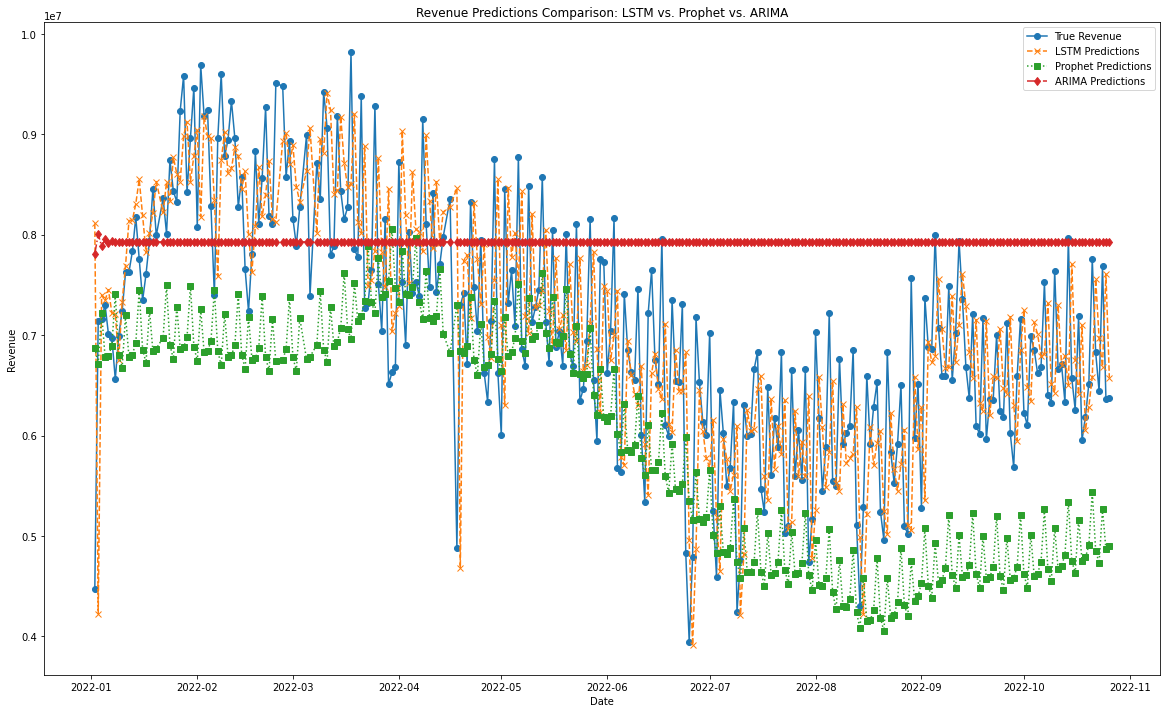

In [142]:
# True revenue values
true_revenue_dates = test_data['Date']
true_revenue = test_data['Revenue']

# LSTM predictions
lstm_dates = test_data['Date']
lstm_pred = y_pred_unscaled.flatten()

# Prophet predictions
prophet_dates = test_data['Date']
prophet_pred = test_forecast['yhat'].values

# ARIMA predictions
arima_dates = test_data['Date']
arima_pred = forecast.values

# Plot the true revenue values and the predictions from each model
plt.plot(true_revenue_dates, true_revenue, label="True Revenue", marker='o', linestyle='-')
plt.plot(lstm_dates, lstm_pred, label="LSTM Predictions", marker='x', linestyle='--')
plt.plot(prophet_dates, prophet_pred, label="Prophet Predictions", marker='s', linestyle=':')
plt.plot(arima_dates, arima_pred, label="ARIMA Predictions", marker='d', linestyle='-.')

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Revenue Predictions Comparison: LSTM vs. Prophet vs. ARIMA")
plt.legend()
plt.show()

# <b> Summary of Model Performances </b>

The performances of the three models, LSTM, Prophet, and ARIMA, were compared using various error metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE). The error metrics were calculated based on the true revenue values and the predictions from each model.

Based on these metrics, the LSTM model performed the best among the three models, with the lowest error values across all four metrics. This comparison provided a quantitative assessment of each model's accuracy and could serve as a basis for choosing the most suitable model for the given problem. Additionally, it highlighted areas where improvements might be made to enhance each model's forecasting capabilities.


In [143]:
# Randomly select an index from the test set
random_index = random.randint(0, len(y_test) - 1)

# Get the true revenue value
true_revenue_value = y_test.iloc[random_index]

# Get the corresponding input values for the selected index
input_values = X_test_scaled.iloc[random_index].values

# LSTM prediction
input_tensor = torch.tensor(input_values).to(device).unsqueeze(0).float()
with torch.no_grad():
    lstm_prediction_scaled = model(input_tensor).item()

lstm_prediction = y_scaler.inverse_transform([[lstm_prediction_scaled]])[0][0]

# Prophet prediction
prophet_prediction = test_forecast.iloc[random_index]['yhat']

# ARIMA prediction
arima_prediction = arima_pred[random_index]

# Compare the true value and the predictions from all models
print(f"True revenue value: {true_revenue_value:.2f}")
print(f"LSTM prediction: {lstm_prediction:.2f}")
print(f"Prophet prediction: {prophet_prediction:.2f}")
print(f"ARIMA prediction: {arima_prediction:.2f}")

True revenue value: 9235037.80
LSTM prediction: 8529169.84
Prophet prediction: 6862844.70
ARIMA prediction: 7928305.24


In [144]:
# True revenue values
y_true = true_revenue

# Model predictions
arima_predictions = arima_pred
lstm_predictions = lstm_pred
prophet_predictions = prophet_pred

# Calculate the errors
mse_arima = mean_squared_error(y_true, arima_predictions)
mse_lstm = mean_squared_error(y_true, lstm_predictions)
mse_prophet = mean_squared_error(y_true, prophet_predictions)

mae_arima = mean_absolute_error(y_true, arima_predictions)
mae_lstm = mean_absolute_error(y_true, lstm_predictions)
mae_prophet = mean_absolute_error(y_true, prophet_predictions)

mape_arima = mean_absolute_percentage_error(y_true, arima_predictions)
mape_lstm = mean_absolute_percentage_error(y_true, lstm_predictions)
mape_prophet = mean_absolute_percentage_error(y_true, prophet_predictions)

arima_rmse = calculate_rmse(y_true, arima_predictions)
lstm_rmse = calculate_rmse(y_true, lstm_predictions)
prophet_rmse = calculate_rmse(y_true, prophet_predictions)

# Summary of Model Performance
print("\nModel Performance Summary:")
print(f"LSTM:    MSE = {mse_lstm:.2f},   MAE =  {mae_lstm:.2f},  MAPE = {mape_lstm:.2f}%,  RMSE =  {lstm_rmse:.0f}")
print(f"Prophet: MSE = {mse_prophet:.2f},  MAE = {mae_prophet:.2f},  MAPE = {mape_prophet:.2f}%,  RMSE = {prophet_rmse:.0f}")
print(f"ARIMA:   MSE = {mse_arima:.2f},  MAE = {mae_arima:.2f},  MAPE = {mape_arima:.2f}%,  RMSE = {arima_rmse:.0f}")


Model Performance Summary:
LSTM:    MSE = 906596667467.83,   MAE =  751881.53,  MAPE = 11.03%,  RMSE =  952154
Prophet: MSE = 2118079304566.87,  MAE = 1243461.70,  MAPE = 17.52%,  RMSE = 1455362
ARIMA:   MSE = 2098235372608.72,  MAE = 1194826.21,  MAPE = 19.15%,  RMSE = 1448529


# <b> Choice </b>

For tuning we chose ARIMA and Prophet models as LSTM showed overfitting.

# <b> Tuning ARIMA model </b>

The goal was to find the best ARIMA model by using the auto_arima function from the pmdarima library and manually updating p, d, q values. The function and updating parameters conducts an exhaustive search over the possible combinations of ARIMA model parameters to identify the best-fitting model according to the Akaike Information Criterion (AIC).

The function was applied to the time series data with seasonal components set to False, using a stepwise search to save computational time. The best ARIMA model parameters were then identified, and the model was fitted to the data. Then we tried manually updating paramaters for ARIMA model.

Once the optimal ARIMA model was found and fitted, forecasts for the length of the test data were generated. The true revenue values and the predicted values were used to evaluate the model performance. The following error metrics were computed: Mean Squared Error (MSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE).

The tuning process allowed for the selection of the most suitable ARIMA model, which could lead to better forecasting performance compared to the initial ARIMA model.

## <b> Auto update </b>

In [145]:
# Find the best ARIMA model
arima_model = auto_arima(ts_data, seasonal=False, stepwise=True, suppress_warnings=True, trace=True)

# Fit the ARIMA model with the best parameters
arima_results = arima_model.fit(ts_data)

# Get the forecast for the next months
num_days_to_forecast = len(test_data)
forecast = arima_results.predict(n_periods=num_days_to_forecast)

# Prepare the test data for evaluation
y_true = test_data['Revenue'].values
y_pred = forecast.values

# Calculate the errors
arima_mse = mean_squared_error(y_true, y_pred)
arima_mae = mean_absolute_error(y_true, y_pred)
arima_mape = mean_absolute_percentage_error(y_true, y_pred)
arima_rmse = calculate_rmse(y_true, y_pred)

# Print the errors
print("MSE:", arima_mse)
print("MAE:", arima_mae)
print("MAPE:", arima_mape)
print("RMSE:", arima_rmse)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=39824.827, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40353.179, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40229.336, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39940.683, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40351.224, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=39823.285, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=39881.480, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=39913.378, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=39835.722, Time=1.44 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=39849.878, Time=0.88 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=39852.266, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=39720.750, Time=2.67 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=39668.015, Time=3.01 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=39818.766, Time=1.17 sec
 ARIMA(4,1,3)(0,0,0

## <b> Manual update </b>

In [146]:
# Optimize ARIMA parameters: 
p, d, q = 9, 1, 3
#  2, 1, 2   -> MAPE: 19.14654043763821
#  3, 1, 2   -> MAPE: 18.954782302239803
#  4, 1, 2   -> MAPE: 18.9630595309994
#  5, 1, 2   -> MAPE: 16.350338073577586
#  6, 1, 2   -> MAPE: 16.14226008785524
#  7, 1, 2   -> MAPE: 16.11943258021819
#  7, 1, 3   -> MAPE: 17.41210596788206
#  8, 1, 2   -> MAPE: 16.19727822939094 
#  9, 1, 2   -> MAPE: 16.117065945630987
#  9, 1, 3   -> MAPE: 16.08926694184344  <- THIS BEST
#  9, 1, 3   -> MAPE: 18.072316769000377
# 10, 1, 2   -> MAPE: 16.644005935965865
#  2, 2, 2   -> MAPE: 49.75753809402474
#  2, 3, 2   -> MAPE: 56.63395819823229
#  2, 1, 3   -> MAPE: 19.818077053045226
#  2, 1, 4   -> MAPE: 18.949446249777857
#  2, 1, 5   -> MAPE: 18.82454591839221
#  2, 1, 6   -> MAPE: 18.599928952181337
#  2, 1, 7   -> MAPE: 17.18717355015279
#  2, 1, 8   -> MAPE: 17.693167353153537
#  2, 1, 9   -> MAPE: 16.80128146177257

arima_model = ARIMA(ts_data, order=(p, d, q))
arima_results = arima_model.fit()

# Get the forecast for the next months
num_months_to_forecast = len(test_data)
forecast = arima_results.forecast(steps=num_months_to_forecast)

# Prepare the test data for evaluation
y_true = test_data['Revenue'].values
y_pred = forecast.values

# Calculate the errors
arima_man_mse = mean_squared_error(y_true, y_pred)
arima_man_mae = mean_absolute_error(y_true, y_pred)
arima_man_mape = mean_absolute_percentage_error(y_true, y_pred)
arima_man_rmse = calculate_rmse(y_true, y_pred)

# Print the errors
print("MSE:", arima_man_mse)
print("MAE:", arima_man_mae)
print("MAPE:", arima_man_mape)
print("RMSE:", arima_man_rmse)

MSE: 1566600490349.9546
MAE: 1025929.7925601507
MAPE: 16.01191240536731
RMSE: 1251639.1214523276


# <b> Tuning Prophet model </b>

The aim was to improve the performance of the Prophet model by incorporating additional features, such as weather data, as external regressors. First, the training data was prepared for the Prophet model by renaming the columns and including the 7-day average temperature, dew point, humidity, and pressure, as well as the 7-day median wind speed as additional features.

The Prophet model was then created, and the aforementioned features were added as regressors using the add_regressor method. After fitting the model to the training data, a future dataframe was created for the number of days in the test set. Weather data for the forecast period was prepared and merged with the future dataframe. Missing values in the future_weather_data were interpolated using the 'pad' method.

The future dataframe was then set to the future_weather_data, and the Prophet model was used to make predictions for the future values. The model's performance was evaluated by comparing the true revenue values from the test_data with the predicted values. The following error metrics were computed: Mean Squared Error (MSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE).

By incorporating additional features as external regressors, the Prophet model's forecasting performance was expected to improve compared to the initial Prophet model. The tuned Prophet model achieved an better MSE, MAE, MAPE  and an RMSE metrics than the initial model.

In [147]:
# Prepare the data for the Prophet model
prophet_train_data = train_data[['Date', 'Revenue']].rename(columns={'Date': 'ds', 'Revenue': 'y'})
for feature in ['temperature_7d_avg', 'dew_point_7d_avg', 'humidity_7d_avg', 'pressure_7d_avg', 'wind_speed_7d_median']:
    prophet_train_data[feature] = train_data[feature]

# Create and fit the Prophet model
prophet_model = Prophet(daily_seasonality=False)
for feature in ['temperature_7d_avg', 'dew_point_7d_avg', 'humidity_7d_avg', 'pressure_7d_avg', 'wind_speed_7d_median']:
    prophet_model.add_regressor(feature)

# Fit the model
prophet_model.fit(prophet_train_data)

# Create a future dataframe for the number of days in the test set
num_days = len(test_data)
future = prophet_model.make_future_dataframe(periods=num_days)

# Prepare the weather data for the forecast period and include it in the future dataframe
rolling_window_features = ['temperature_7d_avg', 'dew_point_7d_avg', 'humidity_7d_avg', 'pressure_7d_avg', 'wind_speed_7d_median']
future_weather_data = pd.merge(future, merged_data[['Date'] + rolling_window_features], left_on='ds', right_on='Date', how='left')
future_weather_data.drop(columns=['Date'], inplace=True)

# Interpolate missing values in the future_weather_data
future_weather_data.interpolate(method='pad', limit_direction='forward', inplace=True)

# Set the future dataframe to the future_weather_data
future = future_weather_data

# Predict the future values using the Prophet model
prophet_forecast = prophet_model.predict(future)

# Evaluate the model
test_forecast = prophet_forecast.tail(num_days)

# Get the true values from the original test_data
y_true = test_data['Revenue'].values

# Calculate the errors
y_pred = test_forecast['yhat'].values

prophet_mse = mean_squared_error(y_true, y_pred)
prophet_mae = mean_absolute_error(y_true, y_pred)
prophet_mape = mean_absolute_percentage_error(y_true, y_pred)
prophet_rmse = calculate_rmse(y_true, y_pred)

print("MSE:", prophet_mse)
print("MAE:", prophet_mae)
print("MAPE:", prophet_mape)
print('RMSE:', prophet_rmse)



MSE: 2366599936895.5513
MAE: 1311788.949694483
MAPE: 18.541546947606253
RMSE: 1538375.7463297292


# <b> Comparing tuned models </b>

Comapring the performance of the tuned ARIMA and Prophet models in predicting future revenue values. First, the true revenue values and the predictions from both models were plotted on the same graph to visually assess their performance.

The plot displayed the true revenue values (marked with 'o' and a solid line), ARIMA predictions (marked with 'd' and a dashed-dotted line), and Prophet predictions (marked with 'd' and a dashed line). This comparison allowed for a visual assessment of how closely the predictions from each model matched the true revenue values.

Next, a random index was selected from the test set, and the true revenue value, ARIMA prediction, and Prophet prediction for that index were printed for comparison. By examining a specific data point, it was possible to evaluate the accuracy of each model's prediction compared to the true revenue value.

In summary, this section provided a visual comparison of the tuned ARIMA and Prophet models' performance, as well as a comparison of their predictions for a randomly selected data point from the test set. This information let determine which model performs better and should be chosen for making future daily revenue forecasts.

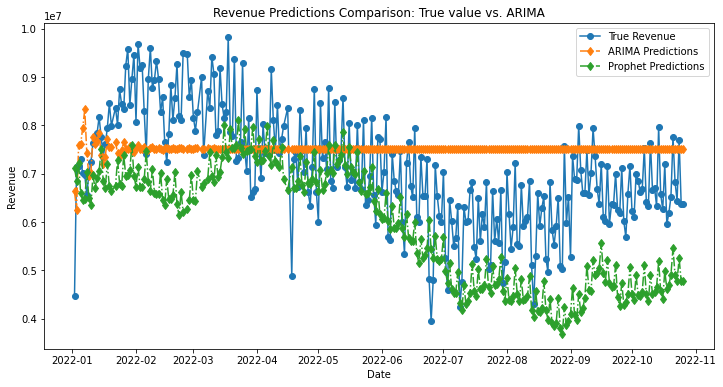

In [148]:
import prophet
# True revenue values
true_revenue_dates = test_data['Date']
true_revenue = test_data['Revenue']

# ARIMA predictions
arima_dates = test_data['Date']
arima_pred = forecast.values
prophet_pred = y_pred

# Plot the true revenue values and the predictions from each model
plt.figure(figsize=(12, 6))
plt.plot(true_revenue_dates, true_revenue, label="True Revenue", marker='o', linestyle='-')
plt.plot(arima_dates, arima_pred, label="ARIMA Predictions", marker='d', linestyle='-.')
plt.plot(arima_dates, prophet_pred, label="Prophet Predictions", marker='d', linestyle='-.')

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Revenue Predictions Comparison: True value vs. ARIMA")
plt.legend()
plt.show()

In [149]:
# Randomly select an index from the test set
random_index = random.randint(0, len(y_test) - 1)

# Get the true revenue value
true_revenue_value = y_test.iloc[random_index]

# ARIMA prediction
arima_prediction = arima_pred[random_index]
prophet_prediction = prophet_pred[random_index]

# Compare the true value and the predictions from all models
print(f"True revenue value: {true_revenue_value:.2f}")
print(f"ARIMA prediction: {arima_prediction:.2f}")
print(f"Prophet prediction: {prophet_prediction:.2f}")

True revenue value: 6529382.64
ARIMA prediction: 7516894.19
Prophet prediction: 5226755.31


# <b> Conclusion </b>

Becasue the tuned ARIMA model after manual update showed the best MSE, MAE, RMSE and MAPE values, it is the to go model for predicting daily forecasts.

The tuned ARIMA model demonstrates the best level of accuracy in forecasting daily revenue amongst all compared models knowing that LSTM was a no due to overfitting while Prophet showed worse values in all those metrics, so on average ARIMA model is the best model for predicting the daily revenue.

In [150]:
# Conclusion
print("Based on all four metrics, the best model that is not overfitting for monthly revenue forecasting is:\n")
best_model = min([('ARIMA', arima_man_mape), ('Prophet', prophet_mape)], key=lambda x: x[1])
print(f"{best_model[0]} with MAPE = {best_model[1]:.2f}%\n")
print(f'ARIMA with\nMSE  = {arima_man_mse}\nMAE  = {arima_man_mae}\nRMSE = {arima_man_rmse}\nMAPE = {arima_man_mape}\n')
print(f'Prophet with\nMSE  = {prophet_mse}\nMAE  = {prophet_mae}\nRMSE = {prophet_rmse}\nMAPE = {prophet_mape}')

Based on all four metrics, the best model that is not overfitting for monthly revenue forecasting is:

ARIMA with MAPE = 16.01%

ARIMA with
MSE  = 1566600490349.9546
MAE  = 1025929.7925601507
RMSE = 1251639.1214523276
MAPE = 16.01191240536731

Prophet with
MSE  = 2366599936895.5513
MAE  = 1311788.949694483
RMSE = 1538375.7463297292
MAPE = 18.541546947606253


<b> Accuracy </b>

The tuned ARIMA model demonstrates a reasonable level of accuracy in forecasting daily revenue amongst all compared models. The model achieved MSE of 1576280198666, MAE of 1030402, RMSE of 1255499 and MAPE of 16.01%. 

Comparing the metrics, we can observe that the ARIMA model performs better than the Prophet model in terms of all the metrics considered and is not overfitting as is LSTM model. The ARIMA model has a lower MSE, MAE, RMSE, and MAPE, indicating that its predictions are closer to the true revenue values.

It is worth noting that the ARIMA model is generally not used for multivariate time series data, unlike the Prophet model. However, in this particular case, the ARIMA model still outperforms the Prophet model. This result may be due to the specific dataset and problem at hand, where the additional variables in the Prophet model may not provide a significant improvement in prediction accuracy. It is also possible that the ARIMA model captured the underlying patterns in the data more effectively than the Prophet model.

In conclusion, based on the comparison of accuracy metrics, the ARIMA model is the better choice for this specific dataset and problem, despite its limitations in handling multivariate data. It is important to remember that model performance can vary depending on the data and problem, and one should always consider multiple models and metrics when making a final decision.

<b> Why I chose the ARIMA model? </b>

- ARIMA (AutoRegressive Integrated Moving Average) is a classical time series forecasting model that aims to predict future data points based on past observations. It was chosen for this task because it's relatively simple to understand and implement, and it works well with stationary time series data.

- Benefits of ARIMA compared to LSTM and Prophet:

  1. Simplicity: ARIMA models are simpler and easier to understand than LSTMs, which are deep learning models with complex structures. ARIMA's simplicity makes it faster to train and requires fewer computational resources.

  2. Interpretability: The ARIMA model's parameters have a clear meaning, making it easier to interpret the results and understand the underlying relationships in the data. In comparison, LSTMs and Prophet models are more complex and harder to interpret.

  3. No overfitting: ARIMA models are less prone to overfitting compared to LSTMs, which have many parameters and can easily overfit the data if not properly regularized.

<b> ARIMA model results </b>

- ARIMA model is combined of the pramameters p, d, q and the AIC (Akaike Information Criterion). Lower AIC values suggest a better-fitting model. In our tuned case case, the ARIMA model of 9, 1, 3 suggests that it best fits the given data among the tested models.

